In [2]:
import wandb
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image
import numpy as np
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, classification_report


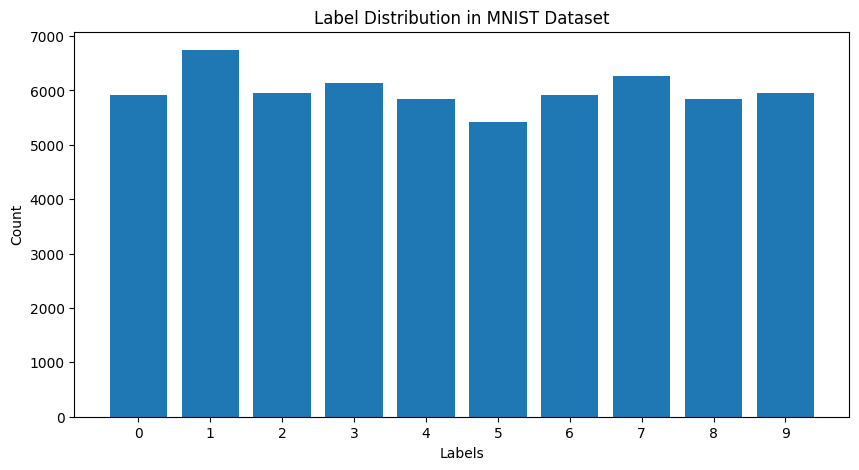

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [4]:
# Define a function to load and visualize the label distribution
def visualize_label_distribution(trainloader):
    label_count = {}
    
    for _, labels in trainloader:
        for label in labels:
            label_count[label.item()] = label_count.get(label.item(), 0) + 1

    labels, counts = zip(*label_count.items())

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts)
    plt.xticks(np.arange(10))
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution in MNIST Dataset')
    plt.show()

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Visualize the label distribution
visualize_label_distribution(trainloader)
print(trainset)

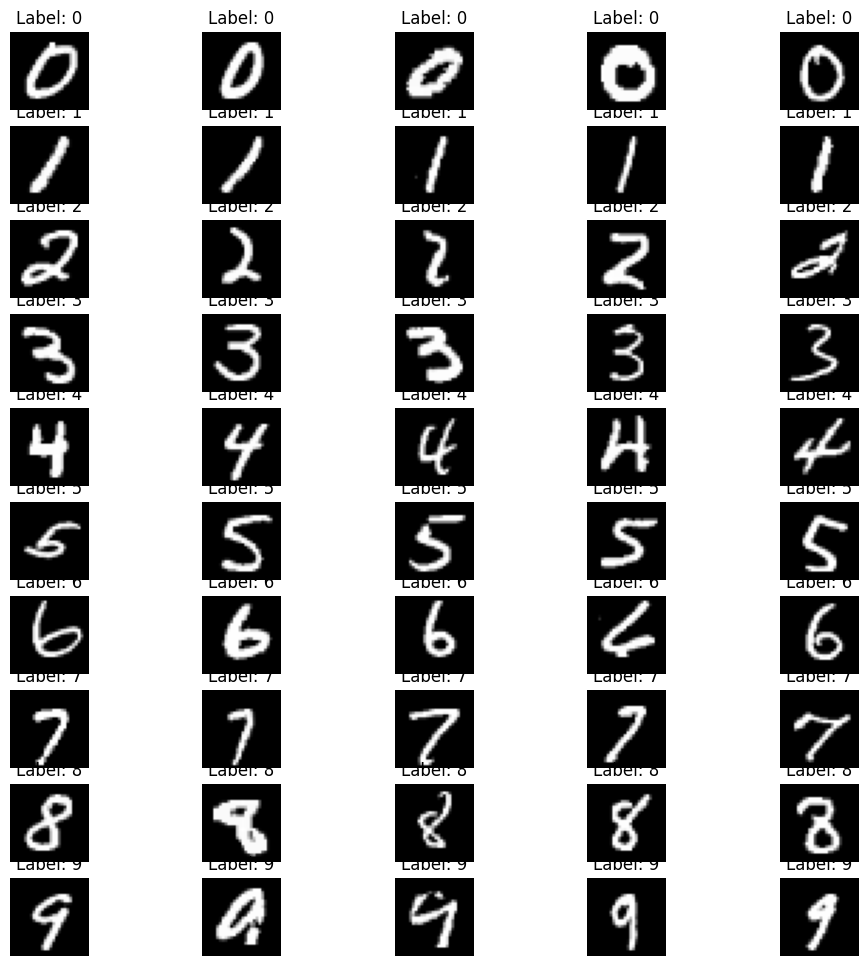

In [4]:
# Define a function to visualize samples from each class
def visualize_samples(trainloader, num_samples=5):
    fig, axes = plt.subplots(10, num_samples, figsize=(12, 12))
    
    sample_images = {}
    for i in range(10):
        sample_images[i] = []

    for images, labels in trainloader:
        for image, label in zip(images, labels):
            if len(sample_images[label.item()]) < num_samples:
                sample_images[label.item()].append(image)

    for i in range(10):
        for j in range(num_samples):
            axes[i, j].imshow(sample_images[i][j][0].numpy(), cmap='gray')
            axes[i, j].set_title(f'Label: {i}')
            axes[i, j].axis('off')

    plt.show()

# Visualize samples from each class
visualize_samples(trainloader, num_samples=5)


In [5]:
from torch.utils.data import random_split

# Define the sizes for train, validation, and test sets
total_size = len(trainset)
train_size = int(0.8 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

# Split the dataset
gen = torch.Generator().manual_seed(42)
train_set, validation_set, test_set = random_split(trainset, [train_size, validation_size, test_size],generator=gen)

# Create data loaders for each set
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)


In [6]:
def visualize_feature_maps(model, layer_num, input_image):
    activation = model.features[:layer_num + 1](input_image)
    
    # Select one of the feature maps (channel)
    feature_map = activation[0, 0].detach().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(feature_map, cmap='viridis')
    plt.axis('off')
    plt.title(f'Feature Map for Layer {layer_num}')
    plt.show()



In [6]:
# Define a CNN model
class SimpleCNN(nn.Module):
    def __init__(self, kernel_size=3, stride=1, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, stride=stride, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, stride=stride, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
net = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [8]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and report the training accuracy and loss
    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Training Loss: {training_loss:.4f}, Training Accuracy: {training_accuracy:.2f}%")

    # Validate the model on the validation set
    correct = 0
    total = 0
    validation_loss = 0.0
    net.eval()

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and report the validation loss and accuracy
    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%")

# After training, you can also evaluate on the test set if needed
correct = 0
total = 0
test_loss = 0.0
net.eval()

with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and report the test loss and accuracy
test_loss = test_loss / len(testloader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1, Training Loss: 0.2827, Training Accuracy: 91.19%
Epoch 1, Validation Loss: 0.0611, Validation Accuracy: 98.20%
Epoch 2, Training Loss: 0.1021, Training Accuracy: 97.05%
Epoch 2, Validation Loss: 0.0528, Validation Accuracy: 98.58%
Epoch 3, Training Loss: 0.0763, Training Accuracy: 97.74%
Epoch 3, Validation Loss: 0.0406, Validation Accuracy: 98.87%
Epoch 4, Training Loss: 0.0653, Training Accuracy: 98.11%
Epoch 4, Validation Loss: 0.0385, Validation Accuracy: 98.87%
Epoch 5, Training Loss: 0.0523, Training Accuracy: 98.35%
Epoch 5, Validation Loss: 0.0381, Validation Accuracy: 98.95%
Test Loss: 0.0442, Test Accuracy: 98.68%


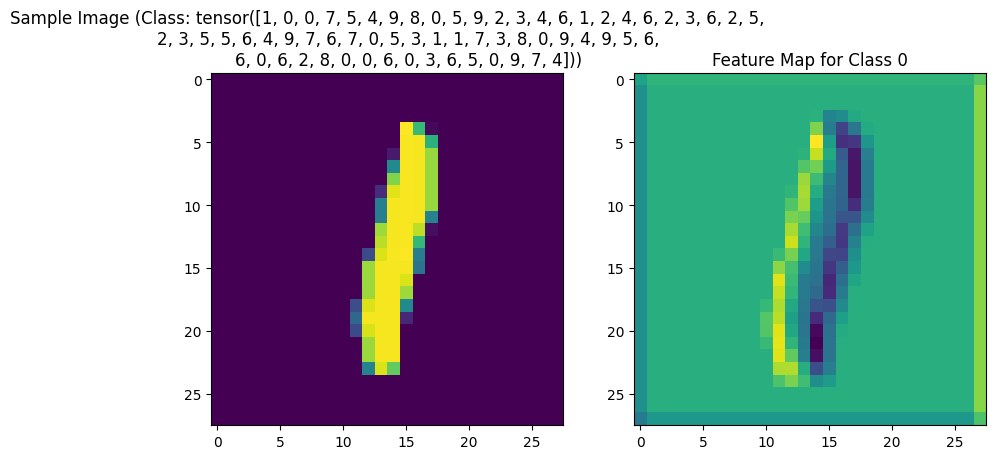

In [9]:
# Choose a sample image from the dataset
sample_loader = iter(testloader)
sample_image, sample_label = next(sample_loader)

# Define a function to display feature maps for a specific class
def display_feature_maps(class_id):
    class_output = net(sample_image)
    activation = net.conv1(sample_image)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[0].permute(1, 2, 0).numpy())
    plt.title(f"Sample Image (Class: {sample_label})")
    
    plt.subplot(1, 2, 2)
    plt.imshow(activation[0, class_id].detach().numpy(), cmap='viridis')
    plt.title(f"Feature Map for Class {class_id}")
    plt.show()

# Display feature maps for a specific class (e.g., class_id = 0)
class_id = 0
display_feature_maps(class_id)


In [13]:
# Initialize W&B
wandb.init(project="mnist_cnn_evaluation")

# Define a configuration for hyperparameter tuning
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 64
wandb.config.kernel_size = 3
wandb.config.stride = 1
wandb.config.epochs = 3
wandb.config.dropout_rate = 0.5

# Create a DataLoader for MNIST
batch_size = wandb.config.batch_size
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True,generator=gen)
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
# Create an instance of the SimpleCNN model
net = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=wandb.config.learning_rate)

for epoch in range(wandb.config.epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate and log training accuracy
    training_loss = running_loss / len(trainloader)
    training_accuracy = 100 * correct_train / total_train
    wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy})

    # Validation loop (similar to the training loop)
    net.eval()
    correct_val = 0
    total_val = 0
    validation_loss = 0.0
    all_predicted = []
    all_actual = []

    with torch.no_grad():
        for data in validationloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_predicted.extend(predicted.tolist())
            all_actual.extend(labels.tolist())

    # Calculate and log validation accuracy and loss
    validation_loss = validation_loss / len(validationloader)
    validation_accuracy = 100 * correct_val / total_val
    wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

    # Calculate and log confusion matrix and class-specific metrics
    conf_matrix = confusion_matrix(all_actual, all_predicted)
    class_metrics = classification_report(all_actual, all_predicted, target_names=[str(i) for i in range(10)], output_dict=True)
    print(conf_matrix)
    print(class_metrics)
    # wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(conf_matrix, class_names=[str(i) for i in range(10)]),
    #            "class_metrics": class_metrics})

wandb.finish()



train_accuracy,▁
train_loss,▁
val_accuracy,▁
val_loss,▁
train_accuracy,91.41458
train_loss,0.27179
val_accuracy,97.95
val_loss,0.06254


[[591   0   1   0   1   1   7   0   3   1]
 [  0 686   1   1   0   0   0   4   1   0]
 [  0   2 597   2   1   0   0  11   7   1]
 [  1   1   1 593   0  12   0   8   2   5]
 [  1   0   1   0 557   0   1   0   0   5]
 [  1   0   0   0   0 525   5   0   2   2]
 [  1   1   0   0   1   0 553   0   0   0]
 [  0   0   0   1   1   0   0 622   0   2]
 [  2   0   1   0   1   2   3   1 570   0]
 [  2   2   0   0   6   3   0   3   2 578]]
{'0': {'precision': 0.986644407345576, 'recall': 0.9768595041322314, 'f1-score': 0.9817275747508306, 'support': 605.0}, '1': {'precision': 0.9913294797687862, 'recall': 0.98989898989899, 'f1-score': 0.9906137184115525, 'support': 693.0}, '2': {'precision': 0.9916943521594684, 'recall': 0.961352657004831, 'f1-score': 0.9762878168438268, 'support': 621.0}, '3': {'precision': 0.9932998324958124, 'recall': 0.9518459069020867, 'f1-score': 0.9721311475409837, 'support': 623.0}, '4': {'precision': 0.9806338028169014, 'recall': 0.9858407079646018, 'f1-score': 0.983230361

train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▃▁
train_accuracy,97.74375
train_loss,0.07482
val_accuracy,98.51667
val_loss,0.0482


In [9]:


# Define the sweep configuration within the script
sweep_config = {
    "name": "mnist-cnn-hyperparam-tuning",
    "method": "grid",
    "metric": {"goal": "maximize", "name": "val_accuracy"},
    "parameters": {
        "learning_rate": {"values": [0.0001, 0.001]},
        "batch_size": {"values": [64, 128]},
        "kernel_size": {"values": [3, 5]},
        "stride": {"values": [1, 2]},
        "epochs": {"values": [3,5]},
        "dropout_rate": {"values": [0.5, 0.7]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="mnist-cnn-hyperparam-tuning")

# Define the training function
def train():
    # Load hyperparameters for this run
    wandb.init(project="mnist-cnn-hyperparam-tuning")
    config = wandb.config
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    kernel_size = config.kernel_size
    stride = config.stride
    epochs = config.epochs
    dropout_rate = config.dropout_rate

    # Create a DataLoader for MNIST

    trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, generator=gen)
    validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

    # Create an instance of the SimpleCNN model
    net = SimpleCNN(kernel_size=kernel_size, stride=stride, dropout_rate=dropout_rate)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate and log training accuracy
        training_loss = running_loss / len(trainloader)
        training_accuracy = 100 * correct_train / total_train
        wandb.log({"train_loss": training_loss, "train_accuracy": training_accuracy})

        # Validation loop
        net.eval()
        correct_val = 0
        total_val = 0
        validation_loss = 0.0
        all_predicted = []
        all_actual = []

        with torch.no_grad():
            for data in validationloader:
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

                all_predicted.extend(predicted.tolist())
                all_actual.extend(labels.tolist())

        # Calculate and log validation accuracy and loss
        validation_loss = validation_loss / len(validationloader)
        validation_accuracy = 100 * correct_val / total_val
        print(validation_accuracy)
        wandb.log({"val_loss": validation_loss, "val_accuracy": validation_accuracy})

# Perform the sweep
wandb.agent(sweep_id, function=train)

Create sweep with ID: 052kumb5
Sweep URL: https://wandb.ai/mourya/mnist-cnn-hyperparam-tuning/sweeps/052kumb5


wandb: Agent Starting Run: 7tzuymn0 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


92.4
95.33333333333333
96.4


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,94.27917
train_loss,0.19643
val_accuracy,96.4
val_loss,0.11424


wandb: Agent Starting Run: hdt9dj66 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run hdt9dj66 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run hdt9dj66 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: 8hcife0p with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.86666666666666
98.3
98.58333333333333


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▅█
val_loss,█▃▁
train_accuracy,97.88125
train_loss,0.07099
val_accuracy,98.58333
val_loss,0.04182


wandb: Agent Starting Run: ri0q212e with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run ri0q212e errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run ri0q212e errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: 41u63dch with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run 41u63dch errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run 41u63dch errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: x2oyr3zz with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run x2oyr3zz errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run x2oyr3zz errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Agent Starting Run: xz3479m7 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run xz3479m7 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run xz3479m7 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: dtrqhghi with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run dtrqhghi errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run dtrqhghi errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Agent Starting Run: i6le2ur2 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


93.96666666666667
96.05
97.18333333333334
97.58333333333333
97.91666666666667


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
train_accuracy,96.8875
train_loss,0.10833
val_accuracy,97.91667
val_loss,0.06824


wandb: Agent Starting Run: aq3wtnjv with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run aq3wtnjv errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run aq3wtnjv errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: 7hiqsfyw with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.86666666666666
98.36666666666666
98.65
99.01666666666667
98.98333333333333


train_accuracy,▁▇▇██
train_loss,█▂▂▁▁
val_accuracy,▁▄▆██
val_loss,█▅▄▂▁
train_accuracy,98.43333
train_loss,0.05201
val_accuracy,98.98333
val_loss,0.03331


wandb: Agent Starting Run: 6chk38k1 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run 6chk38k1 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run 6chk38k1 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: kg1ia1o3 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run kg1ia1o3 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run kg1ia1o3 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: ym1510vv with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run ym1510vv errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run ym1510vv errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sayrz2sc with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run sayrz2sc errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run sayrz2sc errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: uvfw9vge with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run uvfw9vge errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run uvfw9vge errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Agent Starting Run: av40eg2x with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


93.1
95.8
96.81666666666666


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,92.20417
train_loss,0.26877
val_accuracy,96.81667
val_loss,0.11041


wandb: Agent Starting Run: 59ka4ix0 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run 59ka4ix0 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run 59ka4ix0 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: mfy9abmz with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.45
98.38333333333334
98.6


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▇█
val_loss,█▃▁
train_accuracy,95.60625
train_loss,0.14076
val_accuracy,98.6
val_loss,0.04832


wandb: Agent Starting Run: cp5esz8r with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run cp5esz8r errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run cp5esz8r errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: fdf7em3a with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run fdf7em3a errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run fdf7em3a errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: 0qfc3vci with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run 0qfc3vci errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run 0qfc3vci errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ksa5d61j with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run ksa5d61j errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run ksa5d61j errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: 28tfpb4f with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run 28tfpb4f errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run 28tfpb4f errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Agent Starting Run: taxvo9eu with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


92.93333333333334
95.56666666666666
96.73333333333333
97.36666666666666
97.63333333333334


train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
train_accuracy,94.43333
train_loss,0.19568
val_accuracy,97.63333
val_loss,0.07954


wandb: Agent Starting Run: mcsx06ob with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run mcsx06ob errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run mcsx06ob errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: kfo6ogh7 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.36666666666666
98.23333333333333
98.31666666666666
98.58333333333333
98.66666666666667


train_accuracy,▁▆▇██
train_loss,█▃▂▁▁
val_accuracy,▁▆▆██
val_loss,█▃▂▁▁
train_accuracy,96.28542
train_loss,0.11477
val_accuracy,98.66667
val_loss,0.0439


wandb: Agent Starting Run: dj4snl4i with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run dj4snl4i errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: ERROR Run dj4snl4i errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 16384")
wandb: Agent Starting Run: vhrhrqe9 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run vhrhrqe9 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run vhrhrqe9 errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: d6bh3z1j with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run d6bh3z1j errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run d6bh3z1j errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Agent Starting Run: n26s5luu with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run n26s5luu errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: ERROR Run n26s5luu errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 102400")
wandb: Agent Starting Run: gjxmentk with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.7
wandb: 	epochs: 5
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run gjxmentk errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: ERROR Run gjxmentk errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 4096")
wandb: Agent Starting Run: 4t8hf9jb with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


90.85
93.91666666666667
95.5


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,92.52292
train_loss,0.25859
val_accuracy,95.5
val_loss,0.15596


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jvo5lnaa with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run jvo5lnaa errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 32768")
wandb: ERROR Run jvo5lnaa errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 32768")
wandb: Agent Starting Run: fuw0lcsv with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


97.86666666666666
98.43333333333334
98.66666666666667


train_accuracy,▁▇█
train_loss,█▂▁
val_accuracy,▁▆█
val_loss,█▃▁
train_accuracy,97.76042
train_loss,0.07629
val_accuracy,98.66667
val_loss,0.04561


wandb: Agent Starting Run: r3ude5fd with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run r3ude5fd errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 32768")
wandb: ERROR Run r3ude5fd errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 32768")
wandb: Agent Starting Run: q0vsaz5q with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run q0vsaz5q errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 204800")
wandb: ERROR Run q0vsaz5q errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 204800")
wandb: Agent Starting Run: h5nbowhj with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.0001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run h5nbowhj errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 8192")
wandb: ERROR Run h5nbowhj errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 8192")
wandb: Agent Starting Run: izdf1u3u with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run izdf1u3u errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 204800")
wandb: ERROR Run izdf1u3u errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 204800")
wandb: Agent Starting Run: hqoy791g with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 3
wandb: 	kernel_size: 5
wandb: 	learning_rate: 0.001
wandb: 	stride: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Run hqoy791g errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 8192")
wandb: ERROR Run hqoy791g errored: RuntimeError("shape '[-1, 3136]' is invalid for input of size 8192")
wandb: Agent Starting Run: bg8fhymq with config:
wandb: 	batch_size: 128
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	stride: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


92.6
95.2


wandb: Network error (ConnectionError), entering retry loop.


96.6
97.28333333333333


wandb: Network error (ConnectionError), entering retry loop.


97.65


wandb: Ctrl + C detected. Stopping sweep.
